# Inferring an unknown vector

This notebook shows the multivariate extension of hidden state estimation from Chapter 2.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 3 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy.linalg import inv
from scipy.stats import multivariate_normal
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

Imagine that we have an agent located at the origin on a 2D grid. Somewhere on this grid is a food source that it wishes to get to. We define the states of the enviroment by the vector $\boldsymbol{x} \in \mathbb{R}^{C=2}$ which is composed of two elements defining the true position of the food in an $(x, y)$ coordinate pair. Let's suppose that the food itself is obscured by some grass so the agent is not able to determine the exact location of the food. The agent's goal is to take (noisy) samples of the food's position to locate where the food is. 

In this example, we will have no mixing matrix, $\boldsymbol{\Theta} = \boldsymbol{I}$, and no offset $\boldsymbol{b}$, which means that $\boldsymbol{x}$ is related to $\boldsymbol{y}$ purely through noise. This simple scenario will help us get a handle on the linear Gaussian system (LGS) so we can use it in more complex examples.

First, we set up the environment. The environment consists of a true state vector $\boldsymbol{x} = [0.4 \; 0.6]^\top$ and 20 noisy samples of this vector. This means that each time we sample the environment, the sample is a vector of dimension $C=2$. In this example, the output observation vector will have the same dimensions as $\boldsymbol{x}$ so $\boldsymbol{y} \in \mathbb{R}^{D=2=C}$.

In [2]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def _noise(self, cov: float, dim: int):
        return multivariate_normal.rvs(mean=np.zeros(dim), cov=cov)
    
    def _generating_function(self, x_star: np.ndarray) -> float:
        return self.params.Theta_star @ x_star + self.params.b_star
    
    def generate(self, x_star: float) -> float:
        x_noise = self._noise(cov=self.params.cov_x_star, dim=self.params.C)
        y_noise = self._noise(cov=self.params.cov_y_star, dim=self.params.D)
        
        # Noise-ify external states and generate noisy y
        x_star_noise = x_star + x_noise
        return self._generating_function(x_star_noise) + y_noise

In [3]:
""" Environment parameters """
C = 2    # External state dimension
D = 2    # Data dimension
N = 30  # Number of samples

env_params = {
    "Theta_star"  : np.eye(2),                            # Mixing matrix [D X C]
    "cov_x_star"  : 0.1 * np.eye(2),                      # Cov matrix of external states
    "cov_y_star"  : np.array([0.001, 0.001]) * np.eye(2) / N, # Cov matrix of sensory data
    "C"           : C,                                    # External state dimension
    "D"           : D,                                    # Data dimension
    "b_star"      : 0,                                    # Offset [1 x D]
}

# Initialize environment with parameters
env = StaticEnvironment(params=env_params)

# Generate N samples of data data
x_star  = np.array([0.4, 0.6])    # External state
y       = np.zeros((N, D))        # Empty array for N data samples [D x 1]

for idx in range(N):
    y[idx] = env.generate(x_star)

Next, we need to create the agent's model. We will assume that as a prior, the agent assumes that the food is at the position $(0.5, 0.5)$. In the last few hours, the food has rolled away from here so it is no longer in this location. However, since it has not moved far, this is a good assumption for the starting position of where the food might be that will help the agent constrain the space it has to search over. Thus, the prior distribution will have a mean of $\boldsymbol{\mu}_x = [0.5 \; 0.5]^\top$. We will use a spherical covariance matrix of $\boldsymbol{\Sigma} = 0.5 \boldsymbol{I}$. 

To calculate the mean and covariance matrix of the conditional distribution of $p(\boldsymbol{x} \mid \boldsymbol{y})$ we can use the following two equations:

$$
\begin{aligned}
    \boldsymbol{\Sigma}_{x \mid y} &= \left (\boldsymbol{\Sigma}_x^{-1} + n \boldsymbol{\Sigma}_y^{-1} \right )^{-1} \\
    \boldsymbol{\mu}_{x \mid y} &= \boldsymbol{\Sigma}_{x \mid y} \left (\boldsymbol{\Sigma}^{-1}_y (n \bar{\boldsymbol{y}}) + \boldsymbol{\Sigma}_x^{-1} \boldsymbol{\mu}_x \right )
\end{aligned}
$$

These equations directly follow from the mean and covariance matrix of the conditional distribution of a linear Gaussian system.

In [4]:
def create_grid(x_min, x_max):
    X_grid, y_grid = np.mgrid[x_min:x_max:.001, x_min:x_max:.001]
    grid = np.dstack((X_grid, y_grid))
    return grid

In [5]:
class FactorAnalysisAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def infer_states(self, y: np.ndarray):
        Pi_x = inv(self.params.cov_x)
        Pi_y = inv(self.params.cov_y)
        
        self.cov_posterior = inv(Pi_x + self.params.N * Pi_y)
        self.mean_posterior = self.cov_posterior @ (Pi_y @ (self.params.N * np.mean(y, axis=0)) + Pi_x @ self.params.mu_x)
        
        self.posterior = multivariate_normal.pdf(self.params.grid, self.mean_posterior, self.cov_posterior)

In [6]:
x_min, x_max = 0, 1

agent_params = {
    "cov_x" : 0.5 * np.eye(C),                        # Cov matrix of x [D x D]
    "cov_y" : np.array([0.7, 0.6]) * np.eye(2) / N,   # Cov matrix of y [C x C]
    "mu_x"  : np.array([0.5, 0.5]),                   # Mean of x       [D x 1]
    "grid"  : create_grid(x_min, x_max),              # 2D-grid of support of x
    "N"     : N                                       # Number of samples
}

agent = FactorAnalysisAgent(params=agent_params)
agent.infer_states(y)
posterior_probs = agent.posterior

Text(0, 0.5, 'Vertical position')

<Figure size 432x288 with 0 Axes>

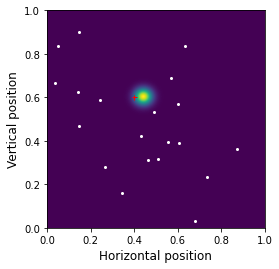

In [7]:
# Plot
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Distribution
ax.imshow(posterior_probs.T, origin="lower", cmap="viridis", extent=[x_min, x_max, x_min, x_max])

# External state
ax.plot(x_star[0], x_star[1], marker="+", color="red", markersize=5)

# Samples
ax.scatter(y[:, 0], y[:, 1], s=4, color="white")
ax.autoscale(False)
ax.set_xlabel("Horizontal position", fontsize=12)
ax.set_ylabel("Vertical position", fontsize=12)

The distribution itself is quite tightly centered near the true position which we can see is a result of the covariance matrix which has a fairly small variance along the diagonal: 

In [8]:
agent.cov_posterior

array([[0.00077657, 0.        ],
       [0.        , 0.00066578]])